In [1]:
import pandas as pd
df = pd.read_csv('japanese_2024_race_laps.csv')
df


,Time,Driver,DriverNumber,LapTime,LapNumber,Stint,PitOutTime,PitInTime,Sector1Time,Sector2Time,...,FreshTyre,Team,LapStartTime,LapStartDate,TrackStatus,Position,Deleted,DeletedReason,FastF1Generated,IsAccurate
0,0 days 01:04:51.506000,VER,1,0 days 00:02:10.735000,1.0,1.0,NaN,0 days 01:04:49.856000,NaN,0 days 00:01:04.045000,...,True,Red Bull Racing,0 days 01:02:40.422000,2024-04-07 05:03:42.056,125,1.0,False,NaN,False,False
1,0 days 01:33:22.630000,VER,1,NaN,2.0,2.0,0 days 01:31:05.329000,NaN,NaN,0 days 00:00:56.617000,...,False,Red Bull Racing,0 days 01:30:58.774000,2024-04-07 05:32:00.408,1,1.0,False,NaN,False,False
2,0 days 01:36:15.449000,VER,1,NaN,3.0,2.0,NaN,NaN,NaN,0 days 00:00:42.768000,...,False,Red Bull Racing,0 days 01:33:22.630000,2024-04-07 05:34:24.264,1,1.0,False,NaN,False,False
3,0 days 01:37:51.921000,VER,1,0 days 00:01:36.472000,4.0,2.0,NaN,NaN,0 days 00:00:34.772000,0 days 00:00:43.042000,...,False,Red Bull Racing,0 days 01:36:15.449000,2024-04-07 05:37:17.083,1,1.0,False,NaN,False,True
4,0 days 01:39:28.358000,VER,1,0 days 00:01:36.437000,5.0,2.0,NaN,NaN,0 days 00:00:34.690000,0 days 00:00:43.035000,...,False,Red Bull Racing,0 days 01:37:51.921000,2024-04-07 05:38:53.555,1,1.0,False,NaN,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
902,0 days 01:48:20.373000,ZHO,24,0 days 00:01:37.500000,10.0,3.0,NaN,NaN,0 days 00:00:35.186000,0 days 00:00:43.455000,...,True,Kick Sauber,0 days 01:46:42.873000,2024-04-07 05:47:44.507,1,18.0,False,NaN,False,True
903,0 days 01:50:01.490000,ZHO,24,0 days 00:01:41.117000,11.0,3.0,NaN,0 days 01:50:00.288000,0 days 00:00:35.334000,0 days 00:00:43.688000,...,True,Kick Sauber,0 days 01:48:20.373000,2024-04-07 05:49:22.007,1,18.0,False,NaN,False,False
904,0 days 01:52:09.683000,ZHO,24,0 days 00:02:08.193000,12.0,4.0,0 days 01:50:27.076000,0 days 01:52:08.494000,0 days 00:00:59.412000,0 days 00:00:46.811000,...,False,Kick Sauber,0 days 01:50:01.490000,2024-04-07 05:51:03.124,1,18.0,False,NaN,False,False
905,0 days 01:04:51.506000,RIC,3,NaN,1.0,1.0,NaN,NaN,NaN,NaN,...,True,RB,0 days 01:02:40.422000,2024-04-07 05:03:42.056,125,NaN,False,NaN,True,False


In [2]:
df['LapTime'] = pd.to_timedelta(df['LapTime'], errors='coerce')
df['LapTimeSeconds'] = df['LapTime'].dt.total_seconds()

In [4]:
voltas_completadas = df.groupby('Driver')['LapNumber'].max()
num_voltas_corrida = 53  # exemplo para Abu Dhabi 2024
limite_conclusao = 0.9 * num_voltas_corrida

concluiu = voltas_completadas >= limite_conclusao

df_features = pd.DataFrame({
    'Driver': voltas_completadas.index,
    'VoltasCompletadasDadosBrutos': voltas_completadas.values,
    'Concluiu': concluiu.values
})

# Resetar o índice para manter um DataFrame limpo
df_features.reset_index(drop=True, inplace=True)

In [5]:
import pandas as pd
import numpy as np

# 1. Criar pits_df com voltas que tem PitInTime ou PitOutTime (opcional, só para pegar dados importantes)
pits_df = df[df['PitInTime'].notna() | df['PitOutTime'].notna()]
pits_df = pits_df[['Driver', 'LapNumber', 'PitInTime', 'PitOutTime', 'Compound', 'TyreLife', 'Stint']]
pits_df = pits_df.sort_values(['Driver', 'LapNumber']).reset_index(drop=True)

# 2. Número de paradas no box por piloto = número de stints - 1
num_stints = df.groupby('Driver')['Stint'].nunique()
pit_counts = (num_stints - 1).rename('NumParadasBox')

# 3. Volta do primeiro pit stop por piloto — pegar a menor volta onde mudou o stint (ou a primeira volta do segundo stint)
# Para isso, pegar a volta mínima para cada piloto onde o stint é > 1
primeiro_pit = df[df['Stint'] > 1].groupby('Driver')['LapNumber'].min().rename('VoltaPrimeiroPit')

# 4. Duração média dos stints por piloto (número médio de voltas por stint)
stint_dur = df.groupby(['Driver', 'Stint']).size().groupby('Driver').mean().rename('DuracaoMediaStint')

# 5. Proporção de voltas por tipo de pneu
voltas_totais = df.groupby('Driver').size()

prop_soft = df[df['Compound'] == 'SOFT'].groupby('Driver').size().divide(voltas_totais).rename('PropVoltasMacios')
prop_medium = df[df['Compound'] == 'MEDIUM'].groupby('Driver').size().divide(voltas_totais).rename('PropVoltasMedios')
prop_hard = df[df['Compound'] == 'HARD'].groupby('Driver').size().divide(voltas_totais).rename('PropVoltasDuros')

# 6. Juntar tudo num DataFrame
df_pit_features = pd.concat([
    pit_counts,
    primeiro_pit,
    stint_dur,
    prop_soft,
    prop_medium,
    prop_hard
], axis=1).reset_index()

# Substituir NaNs por 0 para pilotos sem dados em algumas colunas
df_pit_features.fillna({
    'NumParadasBox': 0,
    'VoltaPrimeiroPit': 0,
    'DuracaoMediaStint': 0,
    'PropVoltasMacios': 0,
    'PropVoltasMedios': 0,
    'PropVoltasDuros': 0
}, inplace=True)

print(df_pit_features.head())


  Driver  NumParadasBox  VoltaPrimeiroPit  DuracaoMediaStint  \
0    ALB              0               0.0               1.00   
1    ALO              3               2.0              13.25   
2    BOT              3               2.0              13.00   
3    GAS              3               2.0              13.00   
4    HAM              3               2.0              13.25   

   PropVoltasMacios  PropVoltasMedios  PropVoltasDuros  
0          1.000000          0.000000         0.000000  
1          0.245283          0.377358         0.377358  
2          0.115385          0.000000         0.884615  
3          0.019231          0.307692         0.673077  
4          0.000000          0.283019         0.716981  


In [6]:
pits_df

,Driver,LapNumber,PitInTime,PitOutTime,Compound,TyreLife,Stint
0,ALO,1.0,0 days 01:04:59.334000,NaN,SOFT,1.0,1.0
1,ALO,2.0,NaN,0 days 01:31:20.261000,SOFT,2.0,2.0
2,ALO,13.0,0 days 01:52:42.913000,NaN,SOFT,13.0,2.0
3,ALO,14.0,NaN,0 days 01:53:05.914000,MEDIUM,1.0,3.0
4,ALO,33.0,0 days 02:25:32.392000,NaN,MEDIUM,20.0,3.0
...,...,...,...,...,...,...,...
103,ZHO,2.0,NaN,0 days 01:32:12,SOFT,1.0,2.0
104,ZHO,7.0,0 days 01:43:06.219000,NaN,SOFT,6.0,2.0
105,ZHO,8.0,NaN,0 days 01:43:29.998000,HARD,1.0,3.0
106,ZHO,11.0,0 days 01:50:00.288000,NaN,HARD,4.0,3.0


In [7]:
df_pit_features

,Driver,NumParadasBox,VoltaPrimeiroPit,DuracaoMediaStint,PropVoltasMacios,PropVoltasMedios,PropVoltasDuros
0,ALB,0,0.0,1.000000,1.000000,0.000000,0.000000
1,ALO,3,2.0,13.250000,0.245283,0.377358,0.377358
2,BOT,3,2.0,13.000000,0.115385,0.000000,0.884615
3,GAS,3,2.0,13.000000,0.019231,0.307692,0.673077
4,HAM,3,2.0,13.250000,0.000000,0.283019,0.716981
5,HUL,3,2.0,13.000000,0.096154,0.000000,0.903846
6,LEC,2,2.0,17.666667,0.000000,0.490566,0.509434
7,MAG,2,2.0,17.333333,0.000000,0.423077,0.576923
8,NOR,3,2.0,13.250000,0.000000,0.207547,0.792453
9,OCO,3,2.0,13.000000,0.019231,0.365385,0.615385


In [8]:
df = df[df['IsAccurate']]


In [9]:
df['IsAccurate'].value_counts()


,count
IsAccurate,
True,785


In [10]:
df['Driver'].value_counts()


,count
Driver,
MAG,48
LEC,48
PER,46
VER,46
NOR,46
SAI,46
RUS,46
PIA,46
HAM,46


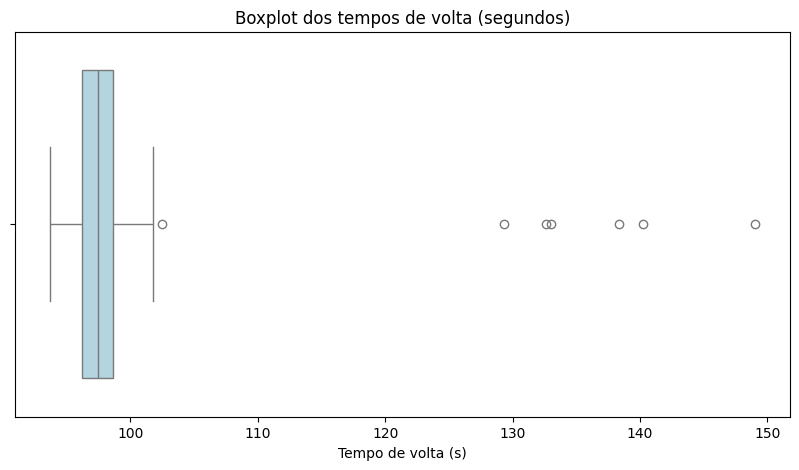

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
sns.boxplot(x=df['LapTimeSeconds'], color='lightblue')
plt.title('Boxplot dos tempos de volta (segundos)')
plt.xlabel('Tempo de volta (s)')
plt.show()


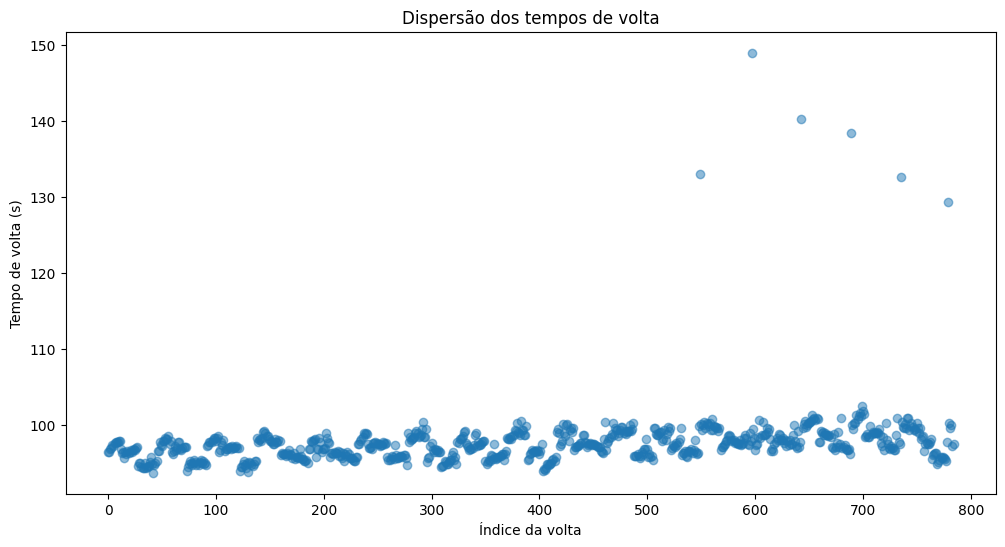

In [12]:
plt.figure(figsize=(12, 6))
plt.scatter(range(len(df)), df['LapTimeSeconds'], alpha=0.5)
plt.title('Dispersão dos tempos de volta')
plt.xlabel('Índice da volta')
plt.ylabel('Tempo de volta (s)')
plt.show()


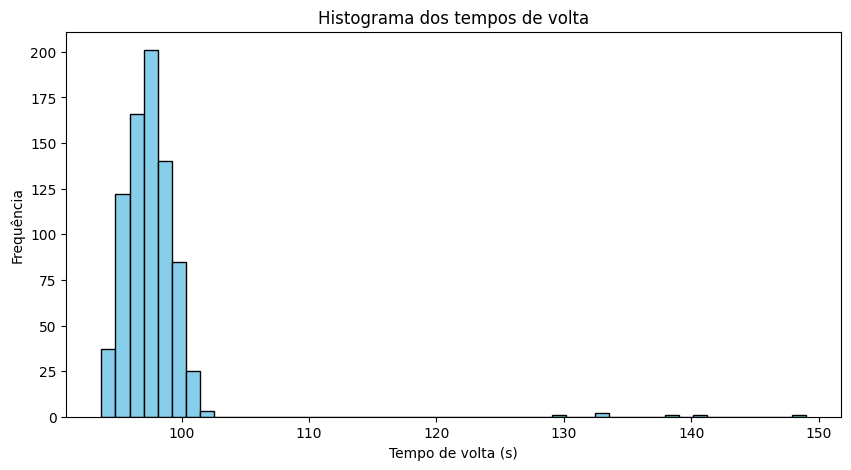

In [13]:
plt.figure(figsize=(10, 5))
plt.hist(df['LapTimeSeconds'], bins=50, color='skyblue', edgecolor='black')
plt.title('Histograma dos tempos de volta')
plt.xlabel('Tempo de volta (s)')
plt.ylabel('Frequência')
plt.show()


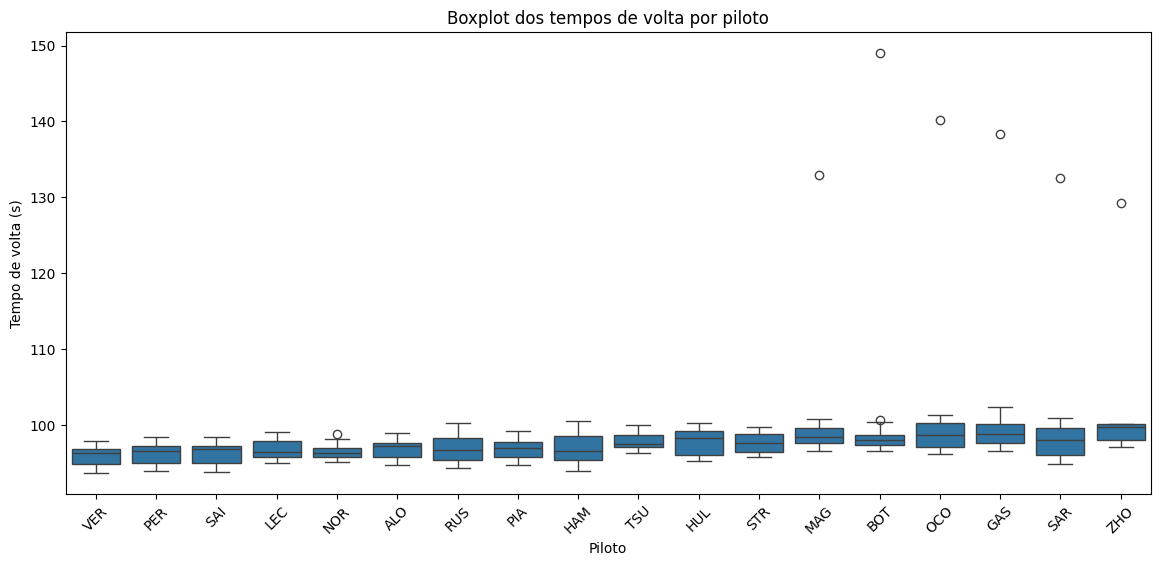

In [14]:
plt.figure(figsize=(14, 6))
sns.boxplot(x='Driver', y='LapTimeSeconds', data=df)
plt.title('Boxplot dos tempos de volta por piloto')
plt.xlabel('Piloto')
plt.ylabel('Tempo de volta (s)')
plt.xticks(rotation=45)
plt.show()


In [15]:
menor_volta_por_piloto = df.groupby('Driver')['LapTime'].min().sort_values()
print(menor_volta_por_piloto)


Driver
VER   0 days 00:01:33.706000
SAI   0 days 00:01:33.841000
PER   0 days 00:01:33.945000
HAM   0 days 00:01:33.952000
RUS   0 days 00:01:34.404000
ALO   0 days 00:01:34.726000
PIA   0 days 00:01:34.802000
SAR   0 days 00:01:34.900000
LEC   0 days 00:01:35.044000
NOR   0 days 00:01:35.186000
HUL   0 days 00:01:35.325000
STR   0 days 00:01:35.798000
OCO   0 days 00:01:36.232000
TSU   0 days 00:01:36.342000
BOT   0 days 00:01:36.608000
GAS   0 days 00:01:36.642000
MAG   0 days 00:01:36.654000
ZHO   0 days 00:01:37.160000
Name: LapTime, dtype: timedelta64[ns]


In [16]:
year = 2024
grand_prix = 'Japao'
race_date = '2024-04-07'  # ex: usar o dado do evento ou da sessão

# Calcular métricas por piloto (como antes)
consistency_df = df.groupby('Driver')['LapTimeSeconds'].agg([
    'count',
    'mean',
    'std',
    'min',
    'max',
    'median'
]).rename(columns={
    'count': 'NumVoltas',
    'mean': 'MediaTempo',
    'std': 'DesvioPadrao',
    'min': 'MelhorVolta',
    'max': 'PiorVolta',
    'median': 'MedianaTempo'
})

consistency_df['RangeTempo'] = consistency_df['PiorVolta'] - consistency_df['MelhorVolta']

# Adicionar colunas fixas
consistency_df['Year'] = year
consistency_df['GrandPrix'] = grand_prix
consistency_df['RaceDate'] = race_date

# Resetar índice para 'Driver' virar coluna normal
consistency_df = consistency_df.reset_index()


In [17]:
consistency_df

,Driver,NumVoltas,MediaTempo,DesvioPadrao,MelhorVolta,PiorVolta,MedianaTempo,RangeTempo,Year,GrandPrix,RaceDate
0,ALO,46,96.910478,1.102898,94.726,98.943,97.2905,4.217,2024,Japao,2024-04-07
1,BOT,46,99.270652,7.555374,96.608,148.991,98.0325,52.383,2024,Japao,2024-04-07
2,GAS,46,99.824217,6.015248,96.642,138.362,98.8270,41.720,2024,Japao,2024-04-07
3,HAM,46,97.006913,1.852732,93.952,100.530,96.6115,6.578,2024,Japao,2024-04-07
4,HUL,45,97.916044,1.614145,95.325,100.374,98.3520,5.049,2024,Japao,2024-04-07
5,LEC,48,96.918250,1.216036,95.044,99.193,96.5190,4.149,2024,Japao,2024-04-07
6,MAG,48,99.312750,5.083445,96.654,132.996,98.4150,36.342,2024,Japao,2024-04-07
7,NOR,46,96.579109,0.937197,95.186,98.888,96.3575,3.702,2024,Japao,2024-04-07
8,OCO,46,99.645413,6.302422,96.232,140.237,98.7325,44.005,2024,Japao,2024-04-07
9,PER,46,96.309457,1.288118,93.945,98.505,96.5705,4.560,2024,Japao,2024-04-07


In [18]:
# Juntar os dois DataFrames pela coluna 'Driver'
df_final = consistency_df.merge(df_features, on='Driver', how='inner')


In [19]:
df_final

,Driver,NumVoltas,MediaTempo,DesvioPadrao,MelhorVolta,PiorVolta,MedianaTempo,RangeTempo,Year,GrandPrix,RaceDate,VoltasCompletadasDadosBrutos,Concluiu
0,ALO,46,96.910478,1.102898,94.726,98.943,97.2905,4.217,2024,Japao,2024-04-07,53.0,True
1,BOT,46,99.270652,7.555374,96.608,148.991,98.0325,52.383,2024,Japao,2024-04-07,52.0,True
2,GAS,46,99.824217,6.015248,96.642,138.362,98.8270,41.720,2024,Japao,2024-04-07,52.0,True
3,HAM,46,97.006913,1.852732,93.952,100.530,96.6115,6.578,2024,Japao,2024-04-07,53.0,True
4,HUL,45,97.916044,1.614145,95.325,100.374,98.3520,5.049,2024,Japao,2024-04-07,52.0,True
5,LEC,48,96.918250,1.216036,95.044,99.193,96.5190,4.149,2024,Japao,2024-04-07,53.0,True
6,MAG,48,99.312750,5.083445,96.654,132.996,98.4150,36.342,2024,Japao,2024-04-07,52.0,True
7,NOR,46,96.579109,0.937197,95.186,98.888,96.3575,3.702,2024,Japao,2024-04-07,53.0,True
8,OCO,46,99.645413,6.302422,96.232,140.237,98.7325,44.005,2024,Japao,2024-04-07,52.0,True
9,PER,46,96.309457,1.288118,93.945,98.505,96.5705,4.560,2024,Japao,2024-04-07,53.0,True


In [20]:
df_pit_features

,Driver,NumParadasBox,VoltaPrimeiroPit,DuracaoMediaStint,PropVoltasMacios,PropVoltasMedios,PropVoltasDuros
0,ALB,0,0.0,1.000000,1.000000,0.000000,0.000000
1,ALO,3,2.0,13.250000,0.245283,0.377358,0.377358
2,BOT,3,2.0,13.000000,0.115385,0.000000,0.884615
3,GAS,3,2.0,13.000000,0.019231,0.307692,0.673077
4,HAM,3,2.0,13.250000,0.000000,0.283019,0.716981
5,HUL,3,2.0,13.000000,0.096154,0.000000,0.903846
6,LEC,2,2.0,17.666667,0.000000,0.490566,0.509434
7,MAG,2,2.0,17.333333,0.000000,0.423077,0.576923
8,NOR,3,2.0,13.250000,0.000000,0.207547,0.792453
9,OCO,3,2.0,13.000000,0.019231,0.365385,0.615385


In [21]:
df_completo = df_final.merge(df_pit_features, on='Driver', how='inner')


In [22]:
df_completo

,Driver,NumVoltas,MediaTempo,DesvioPadrao,MelhorVolta,PiorVolta,MedianaTempo,RangeTempo,Year,GrandPrix,RaceDate,VoltasCompletadasDadosBrutos,Concluiu,NumParadasBox,VoltaPrimeiroPit,DuracaoMediaStint,PropVoltasMacios,PropVoltasMedios,PropVoltasDuros
0,ALO,46,96.910478,1.102898,94.726,98.943,97.2905,4.217,2024,Japao,2024-04-07,53.0,True,3,2.0,13.250000,0.245283,0.377358,0.377358
1,BOT,46,99.270652,7.555374,96.608,148.991,98.0325,52.383,2024,Japao,2024-04-07,52.0,True,3,2.0,13.000000,0.115385,0.000000,0.884615
2,GAS,46,99.824217,6.015248,96.642,138.362,98.8270,41.720,2024,Japao,2024-04-07,52.0,True,3,2.0,13.000000,0.019231,0.307692,0.673077
3,HAM,46,97.006913,1.852732,93.952,100.530,96.6115,6.578,2024,Japao,2024-04-07,53.0,True,3,2.0,13.250000,0.000000,0.283019,0.716981
4,HUL,45,97.916044,1.614145,95.325,100.374,98.3520,5.049,2024,Japao,2024-04-07,52.0,True,3,2.0,13.000000,0.096154,0.000000,0.903846
5,LEC,48,96.918250,1.216036,95.044,99.193,96.5190,4.149,2024,Japao,2024-04-07,53.0,True,2,2.0,17.666667,0.000000,0.490566,0.509434
6,MAG,48,99.312750,5.083445,96.654,132.996,98.4150,36.342,2024,Japao,2024-04-07,52.0,True,2,2.0,17.333333,0.000000,0.423077,0.576923
7,NOR,46,96.579109,0.937197,95.186,98.888,96.3575,3.702,2024,Japao,2024-04-07,53.0,True,3,2.0,13.250000,0.000000,0.207547,0.792453
8,OCO,46,99.645413,6.302422,96.232,140.237,98.7325,44.005,2024,Japao,2024-04-07,52.0,True,3,2.0,13.000000,0.019231,0.365385,0.615385
9,PER,46,96.309457,1.288118,93.945,98.505,96.5705,4.560,2024,Japao,2024-04-07,53.0,True,3,2.0,13.250000,0.000000,0.622642,0.377358


In [23]:
print("Shape final:", df_completo.shape)
print("Pilotos presentes:", df_completo['Driver'].nunique())


Shape final: (18, 19)
Pilotos presentes: 18


In [24]:
df_completo.to_csv('df_completoJapao.csv', index=False)
